# Analyzing Police Activity in Rhode Island

We'll use [The Stanford Open Policing Project data](https://openpolicing.stanford.edu/) to analyze Police Activity in Rhode Island.

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Preparing the Data

In [50]:
# Import the Data
df = pd.read_csv('data/RI_cleaned.csv')

# Examine the head of the DataFrame
df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,stop_duration,out_of_state,drugs_related_stop,district
0,RI-2005-00001,RI,2005-01-02,01:55,Zone K1,NaN,NaN,NaN,600,M,...,False,NaN,NaN,False,Citation,False,0-15 Min,False,False,Zone K1
1,RI-2005-00002,RI,2005-01-02,20:30,Zone X4,NaN,NaN,NaN,500,M,...,False,NaN,NaN,False,Citation,False,16-30 Min,False,False,Zone X4
2,RI-2005-00003,RI,2005-01-04,11:30,Zone X1,NaN,NaN,NaN,0,NaN,...,False,NaN,NaN,False,NaN,NaN,NaN,NaN,False,Zone X1
3,RI-2005-00004,RI,2005-01-04,12:55,Zone X4,NaN,NaN,NaN,500,M,...,False,NaN,NaN,False,Citation,False,0-15 Min,False,False,Zone X4
4,RI-2005-00005,RI,2005-01-06,01:30,Zone X4,NaN,NaN,NaN,500,M,...,False,NaN,NaN,False,Citation,False,0-15 Min,False,False,Zone X4


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509681 entries, 0 to 509680
Data columns (total 26 columns):
id                       509681 non-null object
state                    509681 non-null object
stop_date                509671 non-null object
stop_time                509671 non-null object
location_raw             509681 non-null object
county_name              0 non-null float64
county_fips              0 non-null float64
fine_grained_location    0 non-null float64
police_department        509671 non-null object
driver_gender            480584 non-null object
driver_age_raw           480632 non-null float64
driver_age               478986 non-null float64
driver_race_raw          480608 non-null object
driver_race              480608 non-null object
violation_raw            480608 non-null object
violation                480608 non-null object
search_conducted         509671 non-null object
search_type_raw          17762 non-null object
search_type              17762 non-n

In [52]:
# Shape of the df
df.shape

(509681, 26)

### Dropping Columns and Rows

In [53]:
# Drop the columns which only contain missing values
df.drop(['county_name', 'county_fips', 'fine_grained_location'], axis='columns', inplace=True)

In [54]:
df.shape

(509681, 23)

In [55]:
# The number of missing values in each column
df.isnull().sum()

id                         0
state                      0
stop_date                 10
stop_time                 10
location_raw               0
police_department         10
driver_gender          29097
driver_age_raw         29049
driver_age             30695
driver_race_raw        29073
driver_race            29073
violation_raw          29073
violation              29073
search_conducted          10
search_type_raw       491919
search_type           491919
contraband_found           0
stop_outcome           29073
is_arrested            29073
stop_duration          29073
out_of_state           29881
drugs_related_stop         0
district                   0
dtype: int64

_Driver Gender_ is one of the main columns to be used in this study. Therefore, we'll drop the rows that are missing driver gender information for the purpose of this study. Note that only a small fraction of the rows missing gender info.

In [56]:
# Drop the rows that are missing driver gender information
df.dropna(subset=['driver_gender'], inplace=True)

In [57]:
# The number of missing values in each column
df.isnull().sum()

id                         0
state                      0
stop_date                  0
stop_time                  0
location_raw               0
police_department          0
driver_gender              0
driver_age_raw             1
driver_age              1638
driver_race_raw            0
driver_race                0
violation_raw              0
violation                  0
search_conducted           0
search_type_raw       462822
search_type           462822
contraband_found           0
stop_outcome               0
is_arrested                0
stop_duration              0
out_of_state             808
drugs_related_stop         0
district                   0
dtype: int64

In [58]:
df.shape

(480584, 23)

### Fixing Data Types

In [59]:
df.dtypes

id                     object
state                  object
stop_date              object
stop_time              object
location_raw           object
police_department      object
driver_gender          object
driver_age_raw        float64
driver_age            float64
driver_race_raw        object
driver_race            object
violation_raw          object
violation              object
search_conducted       object
search_type_raw        object
search_type            object
contraband_found         bool
stop_outcome           object
is_arrested            object
stop_duration          object
out_of_state           object
drugs_related_stop       bool
district               object
dtype: object

In [60]:
# Check the data type of 'is_arrested'
df.is_arrested.head()

0    False
1    False
3    False
4    False
5    False
Name: is_arrested, dtype: object

In [61]:
# Change the data type of 'is_arrested' to 'bool'
df['is_arrested'] = df.is_arrested.astype('bool')
df.is_arrested.head()

0    False
1    False
3    False
4    False
5    False
Name: is_arrested, dtype: bool

### Datetime index

We'll concatenate _the stop date_ and _the stop time_ to create a Datetime index.

In [62]:
df[['stop_date', 'stop_time']].head()

,stop_date,stop_time
0,2005-01-02,01:55
1,2005-01-02,20:30
3,2005-01-04,12:55
4,2005-01-06,01:30
5,2005-01-12,08:05


In [63]:
# Concatenate 'stop_date' and 'stop_time' (separated by a space)
stop_datetime = df.stop_date.str.cat(df.stop_time, sep=' ')

# Convert 'stop_datetime' to datetime format
df['stop_datetime'] = pd.to_datetime(stop_datetime)

# Set 'stop_datetime' as the index
df.set_index('stop_datetime', inplace=True)

df.index

DatetimeIndex(['2005-01-02 01:55:00', '2005-01-02 20:30:00',
               '2005-01-04 12:55:00', '2005-01-06 01:30:00',
               '2005-01-12 08:05:00', '2005-01-18 08:15:00',
               '2005-01-18 17:13:00', '2005-01-23 23:15:00',
               '2005-01-24 20:32:00', '2005-02-09 03:05:00',
               ...
               '2015-12-31 22:10:00', '2015-12-31 22:14:00',
               '2015-12-31 22:26:00', '2015-12-31 22:38:00',
               '2015-12-31 22:39:00', '2015-12-31 22:46:00',
               '2015-12-31 22:47:00', '2015-12-31 23:08:00',
               '2015-12-31 23:44:00', '2015-12-31 23:48:00'],
              dtype='datetime64[ns]', name='stop_datetime', length=480584, freq=None)

## Exploring the Data: Gender and Policing

In this section, we'll explore the relationship between gender and policing.

In [64]:
# Unique values in 'violation' column
print(df.violation.value_counts())

# Counts as proportions
print(df.violation.value_counts(normalize=True))

Speeding               268736
Moving violation        90228
Equipment               61250
Other                   24216
Registration/plates     19830
Seat belt               16324
Name: violation, dtype: int64
Speeding               0.559186
Moving violation       0.187747
Equipment              0.127449
Other                  0.050389
Registration/plates    0.041262
Seat belt              0.033967
Name: violation, dtype: float64


More than half of all violations are for speeding, followed by other moving violations.

### Violations by Gender

In [65]:
# DataFrame of female drivers
female = df[df.driver_gender=='F']

# DataFrame of male drivers
male = df[df.driver_gender=='M']

In [66]:
# Violations by female drivers
female.violation.value_counts(normalize=True)

Speeding               0.657308
Moving violation       0.136581
Equipment              0.107055
Registration/plates    0.043077
Other                  0.028908
Seat belt              0.027071
Name: violation, dtype: float64

In [67]:
# Violations by male drivers
male.violation.value_counts(normalize=True)

Speeding               0.522364
Moving violation       0.206948
Equipment              0.135102
Other                  0.058450
Registration/plates    0.040581
Seat belt              0.036555
Name: violation, dtype: float64

Most of the female and male traffic stops apeear to be for speeding. Let's investigate whether the gender have an impact on who gets a ticket for speeding.

In [68]:
# DataFrame of female drivers stopped for speeding
female_and_speeding = df[(df.driver_gender=='F') & (df.violation=='Speeding')]

# DataFrame of male drivers stopped for speeding
male_and_speeding = df[(df.driver_gender=='M') & (df.violation=='Speeding')]

# Stop outcomes for female drivers (as proportions)
print(female_and_speeding.stop_outcome.value_counts(normalize=True))

# Stop outcomes for male drivers (as proportions)
print(male_and_speeding.stop_outcome.value_counts(normalize=True))

Citation            0.953247
Warning             0.039003
Arrest Driver       0.005290
Arrest Passenger    0.001033
N/D                 0.000905
No Action           0.000522
Name: stop_outcome, dtype: float64
Citation            0.944636
Warning             0.036086
Arrest Driver       0.015767
Arrest Passenger    0.001265
N/D                 0.001183
No Action           0.001063
Name: stop_outcome, dtype: float64


The results are similar. It appears that the gender does not have a significant impact on who gets a ticket for speeding.

In [69]:
df.search_conducted.head()

stop_datetime
2005-01-02 01:55:00    False
2005-01-02 20:30:00    False
2005-01-04 12:55:00    False
2005-01-06 01:30:00    False
2005-01-12 08:05:00    False
Name: search_conducted, dtype: object

The data type of `search_conducted` is object. We'll change it to Boolean and calculate the percentage of all stops that result in a car search.

In [70]:
# Change the data type to 'bool'
df['search_conducted'] = df.search_conducted.astype('bool')

# Calculate the search rate by counting the values
print(df.search_conducted.value_counts(normalize=True))

# Calculate the search rate by taking the mean
print(df.search_conducted.mean())

False    0.963041
True     0.036959
Name: search_conducted, dtype: float64
0.036959199640437465


Does the search rate varies by driver gender? We'll now group the data by gender and calculate the search rate for both groups simultaneously.

In [71]:
# Calculate the search rate for both genders
df.groupby('driver_gender')['search_conducted'].mean()

driver_gender
F    0.018751
M    0.043792
Name: search_conducted, dtype: float64

It seems that _the search rate_ varies by driver gender.

In [72]:
# The search rate for both groups simultaneously
df.groupby(['violation', 'driver_gender']).search_conducted.mean()

violation            driver_gender
Equipment            F                0.040245
                     M                0.070916
Moving violation     F                0.038021
                     M                0.059156
Other                F                0.045898
                     M                0.046120
Registration/plates  F                0.054700
                     M                0.103589
Seat belt            F                0.017746
                     M                0.031705
Speeding             F                0.007738
                     M                0.026630
Name: search_conducted, dtype: float64

The search rate is higher for males for all violation types. 

### Protective Frisk Rates by Gender

We'll examine whether gender affects who is frisked.

In [73]:
# Count the 'search_type' values
print(df.search_type.value_counts())

Incident to Arrest                                          6998
Probable Cause                                              4989
Reasonable Suspicion                                        1141
Inventory                                                   1101
Protective Frisk                                             879
Incident to Arrest,Inventory                                 649
Incident to Arrest,Probable Cause                            552
Probable Cause,Reasonable Suspicion                          334
Probable Cause,Protective Frisk                              221
Incident to Arrest,Protective Frisk                          158
Incident to Arrest,Inventory,Probable Cause                  151
Inventory,Probable Cause                                     132
Protective Frisk,Reasonable Suspicion                         83
Incident to Arrest,Inventory,Protective Frisk                 77
Incident to Arrest,Probable Cause,Protective Frisk            74
Inventory,Protective Fris

In [74]:
# Create a bool column where 'search_type' = 'Protective Frisk' -> True
df['frisk'] = df.search_type.str.contains('Protective Frisk', na=False)

# The data type of 'frisk'
print(df['frisk'].dtype)

# Take the sum of 'frisk'
print(df['frisk'].sum())

bool
1598


There were 1538 drivers who were frisked.

In [75]:
# DataFrame of stops in which a search was conducted
searched = df[df.search_conducted==True]

# The overall frisk rate by taking the mean of 'frisk'
print(searched.frisk.mean())

# The frisk rate for each gender
print(searched.groupby('driver_gender').frisk.mean())

0.08996734601959239
driver_gender
F    0.066694
M    0.093707
Name: frisk, dtype: float64


The frisk rate is higher for males than for females.

## Data Visualization

#### Hourly Arrest Rate

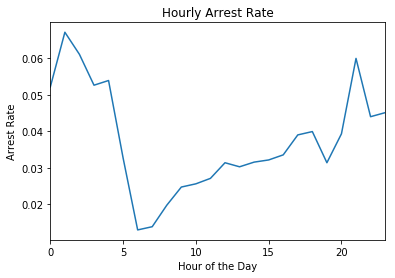

In [76]:
hourly_arrest_rate = df.groupby(df.index.hour).is_arrested.mean()

# Line plot of 'hourly_arrest_rate'
hourly_arrest_rate.plot()
plt.xlabel('Hour of the Day')
plt.ylabel('Arrest Rate')
plt.title('Hourly Arrest Rate')
plt.show()

The arrest rate appears to be lowest in the early morning.

#### Stops Related to Drugs

We'll evaluate whether drug-related stops are becoming more common over time.

In [77]:
df.drugs_related_stop.head()

stop_datetime
2005-01-02 01:55:00    False
2005-01-02 20:30:00    False
2005-01-04 12:55:00    False
2005-01-06 01:30:00    False
2005-01-12 08:05:00    False
Name: drugs_related_stop, dtype: bool

**Resample:**

We use `.resample()` to resample time-series data. 

The DatetimeIndex has an attribute freq with following values: 
 - 'D': daily, 
 - 'H': hourly,
 - 'D': calendar daily, 
 - 'B': business daily, 
 - 'W': weekly, 
 - 'M': monthly, 
 - 'Q': quarterly, 
 - 'A': annual, etc.

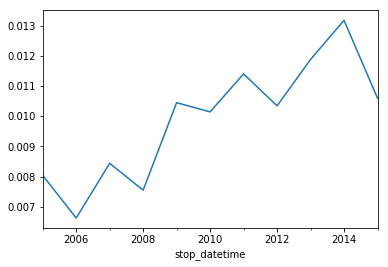

In [78]:
# The annual rate of drug-related stops
annual_drug_rate = df.drugs_related_stop.resample('A').mean()

# Line plot of 'annual_drug_rate'
annual_drug_rate.plot()
plt.show()

The rate of drug-related stops significantly increased over the 10 year period.

**Subplots:**

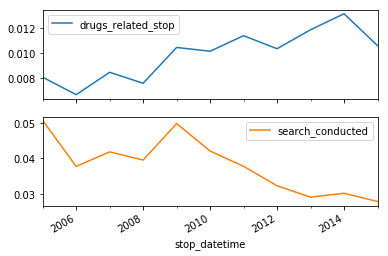

In [79]:
# Annual search rate
annual_search_rate = df.search_conducted.resample('A').mean()

# Concatenate 'annual_drug_rate' and 'annual_search_rate'
annual = pd.concat([annual_drug_rate, annual_search_rate], axis='columns')

# Subplots from 'annual'
annual.plot(subplots=True)

# Display the subplots
plt.show()

### Violations

_crosstab:_

In [80]:
# Create a frequency table of districts and violations
pd.crosstab(df.district, df.violation)

violation,Equipment,Moving violation,Other,Registration/plates,Seat belt,Speeding
district,,,,,,
Zone K1,3786,7127,1501,628,1,33067
Zone K2,11285,16440,5103,4056,2897,57500
Zone K3,12959,16218,3926,3871,3660,68234
Zone X1,1725,3711,752,192,451,6393
Zone X3,11520,17178,4069,3532,4445,48687
Zone X4,19975,29554,8865,7551,4870,54855


How many violations of each type took place in each of the K zones: a comparison.

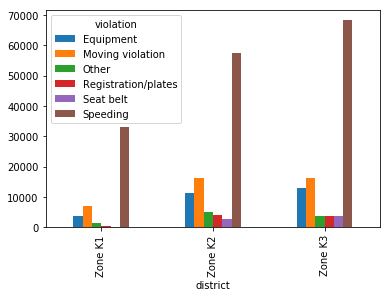

In [81]:
k_zones = pd.crosstab(df.district, df.violation).loc['Zone K1':'Zone K3']

# Bar plot of 'k_zones'
k_zones.plot(kind='bar')
plt.show()

### Stop Durations

In [82]:
# Unique values in 'stop_duration'
df.stop_duration.unique()

array(['0-15 Min', '16-30 Min', '30+ Min', '2', '1'], dtype=object)

In [83]:
# Create a dictionary that maps strings to integers
mapping = {'0-15 Min':8, '16-30 Min':23, '30+ Min':45}

# Convert the 'stop_duration' strings to integers using the 'mapping'
df['stop_minutes'] = df.stop_duration.map(mapping)

# Print the unique values in 'stop_minutes'
df.stop_minutes.unique()

array([ 8., 23., 45., nan])

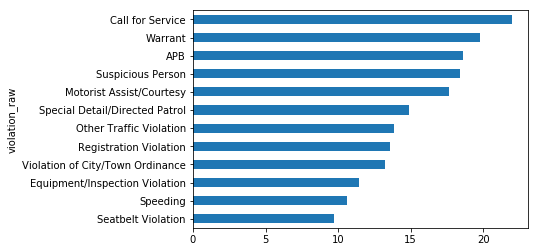

In [84]:
stop_length = df.groupby('violation_raw').stop_minutes.mean()

# Sort 'stop_length' by its values and create a horizontal bar plot
stop_length.sort_values().plot(kind='barh')

# Display the plot
plt.show()